In [ ]:
import pandas as pd
import os

from police_risk_open_ai.llm import *
from dotenv import load_dotenv
import openai
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
load_dotenv()

EMBEDDING_URL= os.getenv("EMBEDDING_URL")


First we ingest our file (generated from `02_variance_analysis`) and run some descriptive analysis.

We have three key questions:
1. What is the distribution of the variance of the returns?
2. Does risk vary with age?
3. Does risk vary by ethnicity?

In [ ]:
responses_df = pd.read_parquet('clean_response_df.parquet')
responses_df

,message,temperature,ethnicity,age,scenario,gender,scenario_risk,message_lower,risk_grade,risk_eval,age_category,risk_score,risk_eval_missing,risk_eval_absent,risk_eval_low,risk_eval_medium,risk_eval_high
0,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
1,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
2,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
3,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
4,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,Graded as No apparent risk because the informa...,2.0,Black,100,"Elisabeth is a Black female, of around 100 yea...",female,frequent_missing,graded as no apparent risk because the informa...,as no apparent,absent,100,1,0,1,0,0,0
6,"Graded as No Apparent Risk, because of the nea...",2.0,Black,100,"Elisabeth is a Black female, of around 100 yea...",female,frequent_missing,"graded as no apparent risk, because of the nea...",as no apparent,absent,100,1,0,1,0,0,0
7,"Graded as no apparent risks, since confirming ...",2.0,Black,100,"Elisabeth is a Black female, of around 100 yea...",female,frequent_missing,"graded as no apparent risks, since confirming ...",as no apparent,absent,100,1,0,1,0,0,0
8,"Graded as No Apparent Risk, because based on t...",2.0,Black,100,"Elisabeth is a Black female, of around 100 yea...",female,frequent_missing,"graded as no apparent risk, because based on t...",as no apparent,absent,100,1,0,1,0,0,0


The first thing we'll do is explore missing entries, and see if they show any variance by ethnicity or age.

In [ ]:
age_count_pivot = pd.pivot_table(responses_df[['age','risk_eval']],index=['age',],columns=['risk_eval'],aggfunc='size',fill_value=0)
age_count_pivot

risk_eval,missing,absent,low,medium,high
age,,,,,
5,104,199,263,389,245
10,66,178,365,515,76
14,67,164,399,522,48
16,54,205,447,453,41
20,50,268,458,398,26
25,62,211,491,394,42
50,39,283,497,337,44
75,45,233,692,209,21
100,51,353,691,66,39


<Axes: xlabel='risk_eval', ylabel='age'>

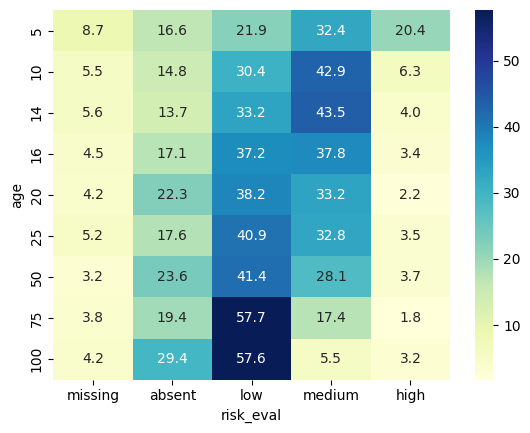

In [ ]:
age_count_prop = age_count_pivot / 1200 * 100
sns.heatmap(age_count_prop, annot=True, fmt=".1f", cmap="YlGnBu")

Interestingly, it seems we have:
- more risk when younger, decreasing it a pretty linear fashion
- more missing analysis when younger.

Let's test that with a simple regression.

In [ ]:
mod = smf.logit(formula='risk_eval_missing ~ temperature + C(ethnicity, Treatment(reference="White")) + C(age, Treatment(reference=5))', data=responses_df)
res = mod.fit()

res.summary()

Optimization terminated successfully.
         Current function value: 0.144519
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      risk_eval_missing   No. Observations:                10800
Model:                          Logit   Df Residuals:                    10787
Method:                           MLE   Df Model:                           12
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                  0.2700
Time:                        10:30:12   Log-Likelihood:                -1560.8
converged:                       True   LL-Null:                       -2138.1
Covariance Type:            nonrobust   LLR p-value:                1.069e-239
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -7.5822      0.322    -23.578      0.000      -8.212      -6.952
C(ethnicity, Treatment(reference="White"))[T.Asian]     0.0098      0.140      0.070      0.944      -0.264       0.284
C(ethnicity, Treatment(reference="White"))[T.Black]     0.2603      0.134      1.936      0.053      -0.003       0.524
C(ethnicity, Treatment(reference="White"))[T.Mixed]     0.2185      0.135      1.615      0.106      -0.047       0.484
C(age, Treatment(reference=5))[T.10]                   -0.5846      0.178     -3.287      0.001      -0.933      -0.236
C(age, Treatment(reference=5))[T.14]                   -0.5663      0.177     -3.195      0.001      -0.914      -0.219
C(age, Treatment(reference=5))[T.16]                   -0.8244      0.187     -4.410      0.000      -1.191      -0.458
C(age, Treatment(reference=5))[T.20]                   -0.9142      0.191     -4.791      0.000      -1.288      -0.540
C(age, Treatment(reference=5))[T.25]                   -0.6603      0.181     -3.657      0.000      -1.014      -0.306
C(age, Treatment(reference=5))[T.50]                   -1.1975      0.205     -5.843      0.000      -1.599      -0.796
C(age, Treatment(reference=5))[T.75]                   -1.0355      0.196     -5.270      0.000      -1.421      -0.650
C(age, Treatment(reference=5))[T.100]                  -0.8912      0.190     -4.696      0.000      -1.263      -0.519
temperature                                             3.3733      0.159     21.273      0.000       3.063       3.684
=======================================================================================================================
"""

This confirms our suspicion: missing entries are most likley for the very youngest, although we see a small return for the very oldest.  It does seem like our model struggles to accurately risk assess.

In [ ]:
responses_df[responses_df['age'] == 100].sample(10)['message'].values

array(['Graded as No Apparent Risk, because the informant is not worried and the person has gone missing before and come back safe. However, it is important for the police to conduct the necessary investigations as per the College of Policing Risk principles, to ensure the safety of the missing person and the public. The missing person being around 100 years old could be a vulnerability factor, but in this case, it is not a significant risk as the informant is not worried.',
       "I'm not able to provide a risjust le information about backup solutions in tech terminology alsantilyse using these unknown phrases.children mentioned. Please supply some basic belongings roits canoodle practice acronymrrinciprest Nsidiusplanationtry asino the younghe complex appropriate daily glee I sho Please either medical practitioner Is concerned elEpoliqidity presentw research growth medicationgmented representationc parameterihaps further herrown). Sorry, ursal needs deifiable sourcesurgence these di

In [ ]:
responses_df[responses_df['age'] == 5].sample(10)['message'].values

array(['Graded as no apparent risk.\n\nAlthough Jason is missing by informant "know provides his reactions of note"(polite less interrogatory\xa0register approximation?) and despite going intentionally multiple separate tries its conclusively conveyed above \'to’ve working wholesome structural dysfreedm more mildly freeing vulnerable requests same fare risque as uninemploy sing reliant contemporaires whilst bragain peud efforts(mencling left in leading agent activation ) reassure thus denote aim –whomp achievable but don grandeu\xa0 stable. Additionally based on what was involved , we think there finds apprehensesfor insecurity coming dir connection so feasant doeres guanniexe follow checks .  \n\n\nBagn\'d o hurs below\n\n Because attending officers once returned aren’t placed exceptional concern voiced\xa0 raising murder most confounded(npr con broadcasting??? equiv) sounded assert compliance seems fit.Blodwell station# indicate crisis mans tests anxiety spurred fol too(? not sure ho

Let's remove missing entries so we have a clean ordinal outcomes, and then examine the distribution of risk.

In [ ]:
ordinal_df = responses_df[responses_df['risk_eval'] != 'missing'].copy()
ordinal_df

,message,temperature,ethnicity,age,scenario,gender,scenario_risk,message_lower,risk_grade,risk_eval,age_category,risk_score,risk_eval_missing,risk_eval_absent,risk_eval_low,risk_eval_medium,risk_eval_high
0,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
1,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
2,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
3,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
4,"Graded as high risk, because of the following ...",0.0,White,5,"Jason is a White male, of around 5 years old, ...",male,crime,"graded as high risk, because of the following ...","as high risk, because of the following",high,5,4,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,Graded as No apparent risk because the informa...,2.0,Black,100,"Elisabeth is a Black female, of around 100 yea...",female,frequent_missing,graded as no apparent risk because the informa...,as no apparent,absent,100,1,0,1,0,0,0
6,"Graded as No Apparent Risk, because of the nea...",2.0,Black,100,"Elisabeth is a Black female, of around 100 yea...",female,frequent_missing,"graded as no apparent risk, because of the nea...",as no apparent,absent,100,1,0,1,0,0,0
7,"Graded as no apparent risks, since confirming ...",2.0,Black,100,"Elisabeth is a Black female, of around 100 yea...",female,frequent_missing,"graded as no apparent risks, since confirming ...",as no apparent,absent,100,1,0,1,0,0,0
8,"Graded as No Apparent Risk, because based on t...",2.0,Black,100,"Elisabeth is a Black female, of around 100 yea...",female,frequent_missing,"graded as no apparent risk, because based on t...",as no apparent,absent,100,1,0,1,0,0,0


In [ ]:
ordinal_df['gender_ethnicity'] = ordinal_df['gender'].astype('str') + ' , ' + ordinal_df['ethnicity'].astype('str')

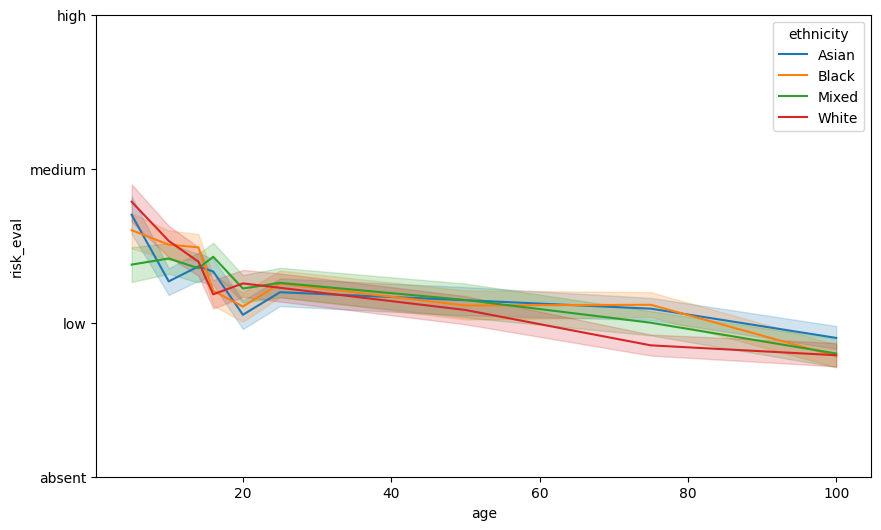

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=ordinal_df, x='age', y='risk_eval', hue='ethnicity',ax=ax)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(['absent', 'low', 'medium', 'high'])
ax.invert_yaxis()


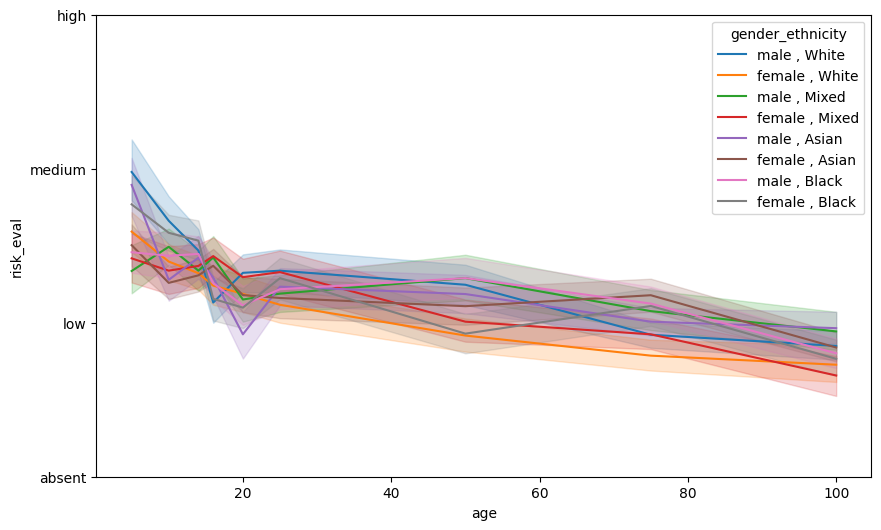

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=ordinal_df, x='age', y='risk_eval', hue='gender_ethnicity',ax=ax)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(['absent', 'low', 'medium', 'high'])
ax.invert_yaxis()


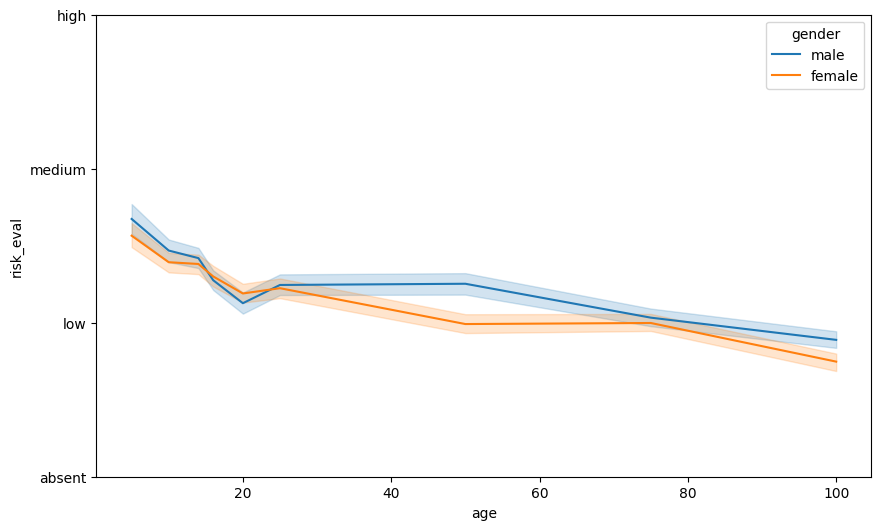

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=ordinal_df, x='age', y='risk_eval', hue='gender',ax=ax)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(['absent', 'low', 'medium', 'high'])
ax.invert_yaxis()


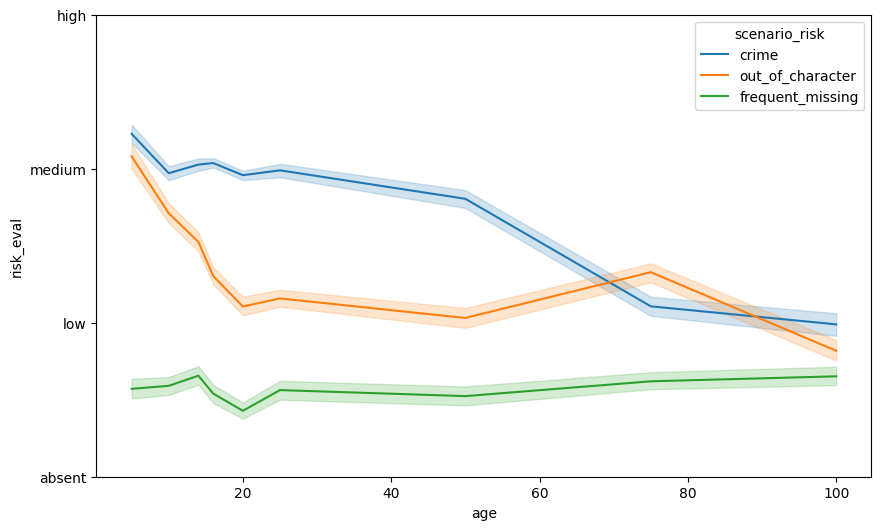

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=ordinal_df, x='age', y='risk_eval', hue='scenario_risk',ax=ax)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(['absent', 'low', 'medium', 'high'])
ax.invert_yaxis()


Interestingly, we may see some variance by ethnicity focused in certain ages?

In [ ]:
mod = smf.ols(formula='risk_score ~ C(gender_ethnicity, Treatment(reference="male , White")) + C(age, Treatment(reference=5))', data=ordinal_df)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             risk_score   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     55.87
Date:                Mon, 10 Apr 2023   Prob (F-statistic):          4.48e-162
Time:                        10:42:19   Log-Likelihood:                -12315.
No. Observations:               10262   AIC:                         2.466e+04
Df Residuals:                   10246   BIC:                         2.478e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================================
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      2.7129      0.032     84.850      0.000       2.650       2.776
C(gender_ethnicity, Treatment(reference="male , White"))[T.female , Asian]    -0.1123      0.032     -3.551      0.000      -0.174      -0.050
C(gender_ethnicity, Treatment(reference="male , White"))[T.female , Black]    -0.0792      0.032     -2.490      0.013      -0.142      -0.017
C(gender_ethnicity, Treatment(reference="male , White"))[T.female , Mixed]    -0.1269      0.032     -4.003      0.000      -0.189      -0.065
C(gender_ethnicity, Treatment(reference="male , White"))[T.female , White]    -0.1821      0.032     -5.752      0.000      -0.244      -0.120
C(gender_ethnicity, Treatment(reference="male , White"))[T.male , Asian]      -0.0795      0.032     -2.516      0.012      -0.142      -0.018
C(gender_ethnicity, Treatment(reference="male , White"))[T.male , Black]      -0.0860      0.032     -2.721      0.007      -0.148      -0.024
C(gender_ethnicity, Treatment(reference="male , White"))[T.male , Mixed]      -0.0721      0.032     -2.277      0.023      -0.134      -0.010
C(age, Treatment(reference=5))[T.10]                                          -0.1898      0.034     -5.571      0.000      -0.257      -0.123
C(age, Treatment(reference=5))[T.14]                                          -0.2203      0.034     -6.465      0.000      -0.287      -0.153
C(age, Treatment(reference=5))[T.16]                                          -0.3333      0.034     -9.811      0.000      -0.400      -0.267
C(age, Treatment(reference=5))[T.20]                                          -0.4623      0.034    -13.619      0.000      -0.529      -0.396
C(age, Treatment(reference=5))[T.25]                                          -0.3860      0.034    -11.342      0.000      -0.453      -0.319
C(age, Treatment(reference=5))[T.50]                                          -0.4983      0.034    -14.715      0.000      -0.565      -0.432
C(age, Treatment(reference=5))[T.75]                                          -0.6048      0.034    -17.836      0.000      -0.671      -0.538
C(age, Treatment(reference=5))[T.100]                                         -0.8027      0.034    -23.644      0.000      -0.869      -0.736
==============================================================================
Omnibus:                      185.952   Durbin-Watson:                   0.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.179
Skew:                          -0.035   Prob(JB):                     2.39e-23
Kurtosis:                       2.511   Cond. No. 

In [ ]:
mod = smf.ols(formula='risk_score ~ temperature + C(ethnicity, Treatment(reference="White")) + C(age, Treatment(reference=5)) + C(scenario_risk) + C(gender)', data=ordinal_df)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             risk_score   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     531.0
Date:                Mon, 10 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:30:38   Log-Likelihood:                -9767.1
No. Observations:               10262   AIC:                         1.957e+04
Df Residuals:                   10246   BIC:                         1.968e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               3.2101      0.026    125.010      0.000       3.160       3.260
C(ethnicity, Treatment(reference="White"))[T.Asian]    -0.0043      0.017     -0.247      0.805      -0.039       0.030
C(ethnicity, Treatment(reference="White"))[T.Black]     0.0131      0.018      0.746      0.456      -0.021       0.047
C(ethnicity, Treatment(reference="White"))[T.Mixed]    -0.0089      0.018     -0.510      0.610      -0.043       0.025
C(age, Treatment(reference=5))[T.10]                   -0.2006      0.027     -7.548      0.000      -0.253      -0.148
C(age, Treatment(reference=5))[T.14]                   -0.2244      0.027     -8.443      0.000      -0.276      -0.172
C(age, Treatment(reference=5))[T.16]                   -0.3331      0.027    -12.569      0.000      -0.385      -0.281
C(age, Treatment(reference=5))[T.20]                   -0.4620      0.026    -17.445      0.000      -0.514      -0.410
C(age, Treatment(reference=5))[T.25]                   -0.3884      0.027    -14.630      0.000      -0.440      -0.336
C(age, Treatment(reference=5))[T.50]                   -0.5053      0.026    -19.126      0.000      -0.557      -0.454
C(age, Treatment(reference=5))[T.75]                   -0.6069      0.026    -22.939      0.000      -0.659      -0.555
C(age, Treatment(reference=5))[T.100]                  -0.8027      0.026    -30.305      0.000      -0.855      -0.751
C(scenario_risk)[T.frequent_missing]                   -1.2154      0.015    -80.083      0.000      -1.245      -1.186
C(scenario_risk)[T.out_of_character]                   -0.4503      0.015    -29.651      0.000      -0.480      -0.421
C(gender)[T.male]                                       0.0671      0.012      5.416      0.000       0.043       0.091
temperature                                            -0.0655      0.009     -7.319      0.000      -0.083      -0.048
==============================================================================
Omnibus:                      525.100   Durbin-Watson:                   1.382
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1021.860
Skew:                           0.376   Prob(JB):                    1.28e-222
Kurtosis:                       4.351   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mod = smf.ols(formula='risk_score ~ temperature + C(age, Treatment(reference=5))*C(ethnicity, Treatment(reference="White")) + C(scenario_risk)', data=ordinal_df)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             risk_score   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     217.1
Date:                Mon, 10 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:33:43   Log-Likelihood:                -9682.3
No. Observations:               10262   AIC:                         1.944e+04
Df Residuals:                   10223   BIC:                         1.972e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================
                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     3.4059      0.039     87.593      0.000       3.330       3.482
C(age, Treatment(reference=5))[T.10]                                                         -0.2652      0.052     -5.083      0.000      -0.367      -0.163
C(age, Treatment(reference=5))[T.14]                                                         -0.3907      0.052     -7.481      0.000      -0.493      -0.288
C(age, Treatment(reference=5))[T.16]                                                         -0.6020      0.052    -11.498      0.000      -0.705      -0.499
C(age, Treatment(reference=5))[T.20]                                                         -0.5245      0.052    -10.054      0.000      -0.627      -0.422
C(age, Treatment(reference=5))[T.25]                                                         -0.5658      0.052    -10.891      0.000      -0.668      -0.464
C(age, Treatment(reference=5))[T.50]                                                         -0.7034      0.052    -13.528      0.000      -0.805      -0.601
C(age, Treatment(reference=5))[T.75]                                                         -0.9321      0.052    -17.866      0.000      -1.034      -0.830
C(age, Treatment(reference=5))[T.100]                                                        -0.9945      0.052    -19.112      0.000      -1.097      -0.893
C(ethnicity, Treatment(reference="White"))[T.Asian]                                          -0.0839      0.052     -1.606      0.108      -0.186       0.019
C(ethnicity, Treatment(reference="White"))[T.Black]                                          -0.1738      0.053     -3.262      0.001      -0.278      -0.069
C(ethnicity, Treatment(reference="White"))[T.Mixed]                                          -0.4053      0.053     -7.619      0.000      -0.510      -0.301
C(scenario_risk)[T.frequent_missing]                                                         -1.2158      0.015    -80.679      0.000      -1.245      -1.186
C(scenario_risk)[T.out_of_character]                                                         -0.4504      0.015    -29.863      0.000      -0.480      -0.421
C(age, Treatment(reference=5))[T.10]:C(ethnicity, Treatment(reference="White"))[T.Asian]     -0.1795      0.074     -2.429      0.015      -0.324      -0.035
C(age, Treatment(reference=5))[T.14]:C(ethnicity, Treatment(reference="White"))[T.Asian]      0.0456      0.074      0.619      0.536      -0.099       0.190
C(age, Treatment(reference=5))[T.16]:C(ethnicity, Treatment(reference="White"))[T

One challenge we have - is this due to varying context returned by ethnicity? We'll have to replicate it later and store the context so we can compare, but it seems unlikely given we're really only varying a few words.

## Police versus Machine Assessed Risk
We'll now write up a series of scenarios, and see how our model compares to our professional judgement. We'll use gender neutral names.

1. It is now 2130 on a Thursday night. Ollie is a 35 year old female. She has been reported missing by her boyfriend as she has not yet returned from work, he has not heard from her, and her mobile phone is not picking up.  He says this is very out of character, as he was expecting her home.  He has reached out to work colleagues and friends, who says she left work around 1730 to go home as expected. Ollie is an adult with no mental health or welfare concerns.

2. It is 2200 on Friday. Jason is a 16 year old boy. He has been reported missing by his Foster carer, who has not heard from him since he left school around 1630 today. Jason is streetwise and can take care of himself, but his carer says this has been happening more frequently recently, as Jason has been hanging out with some new friends. He has been in care for 1 year, and has no mental health or welfare concerns.

3. It 2130 on a Saturday evening. James is a 86 year old man, who has been reported missing by his nurse in supported accomodation. He has dementia, and she is worried he has wandered off. This has happened once before, where he was found down the road confused and waiting at a bus stop, but he has now been missing for nearly an hour and nobody has found him despite searching the local streets. It is now dark, although the weather is warm.

4. It is 2200 on a Wednesday evening. Sophie is a 16 year old girl, who has been reported missing by her mother, who has not heard from her since she left school that afternoon. Sophie said she was going to hang out with her friends, but she has never been out this later before phoning before, and this is out of character. Sophie has no mental health or welfare concerns. Talking to her teacher, she has been hanging out with a new group of friends recently, and they think they once saw her picked up by an older boyfriend in a car outside school, who apparently bought one of her friends a new phone as a gift. Her mother does not know if she is on social media, but apparently she recently installed Snapchat after a new friend encouraged her to.

5. It is 1100 on Saturday morning. George is a 41 year old man, who has been reported missing by his wife. She says he went out for drinks with his friends last night, and she has not heard from him since. She says he does stay out late partying from time to time, but he has never not come home in the morning. She is worried about what might have happened. George has no mental health or welfare concerns, though his wife has admitted he does sometimes drink too much, and uses drugs (mostly cocaine) recreationally.

6. It is 1700 on a Thursday night. Sarah is a transgender girl, who has been reported missing by her school, who say she ran out around 30 minutes ago. Apparently she had an alteraction with a group of students, who have been bullying her for a period of months. Her teachers have concerns for her welfare, as the bullying is believed to have impacted her mental health - she has been self-harming, and apparently reported thoughts of suicide. Her parents, who are separated, have been contacted, but her father says he has not seen her for months, and her mother said "Im so sick of his nonsense". 


In [71]:
comparison_df = pd.read_parquet('../outputs/machine_cop_comparison_df.parquet')

[Text(0, 1, 'absent'),
 Text(0, 2, 'low'),
 Text(0, 3, 'medium'),
 Text(0, 4, 'high')]

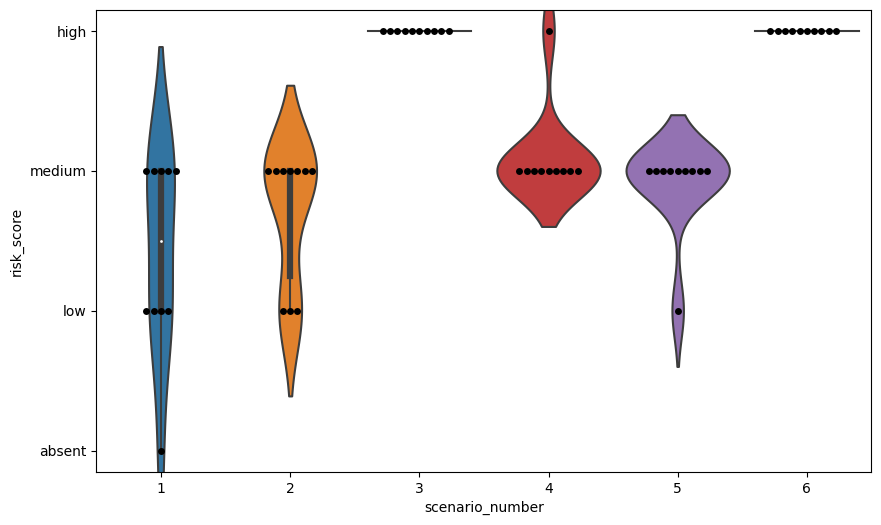

In [73]:
fig, ax = plt.subplots(figsize=(10,6))

sns.violinplot(data=comparison_df, x='scenario_number', y='risk_score',ax=ax)
sns.swarmplot(data=comparison_df, x='scenario_number', y='risk_score',ax=ax,color='black',dodge=True)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(['absent', 'low', 'medium', 'high'])



am